In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget

from sklearn.feature_selection import f_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

In [3]:
vars = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
cat_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
cont_vars = [var for var in vars if var not in cat_vars]

fname = wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data')

df = pd.read_csv(fname, names=vars+['num'], na_values='?')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [5]:
df['diagnosed'] = df.num > 0
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnosed
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,False
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,True
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,True
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,False
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,False


## Mean imputation for missing vars

'ca' and 'thal' have some missing values.
For 'ca', mean imputation makes sense.
For 'thal', fill the missing values with the 'normal' value (3), which is the most common.

In [6]:
df = df.fillna({'ca': df.ca.mean(), 'thal': df.thal.mode()[0]})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        303 non-null    float64
 1   sex        303 non-null    float64
 2   cp         303 non-null    float64
 3   trestbps   303 non-null    float64
 4   chol       303 non-null    float64
 5   fbs        303 non-null    float64
 6   restecg    303 non-null    float64
 7   thalach    303 non-null    float64
 8   exang      303 non-null    float64
 9   oldpeak    303 non-null    float64
 10  slope      303 non-null    float64
 11  ca         303 non-null    float64
 12  thal       303 non-null    float64
 13  num        303 non-null    int64  
 14  diagnosed  303 non-null    bool   
dtypes: bool(1), float64(13), int64(1)
memory usage: 33.6 KB


## Data Exploration

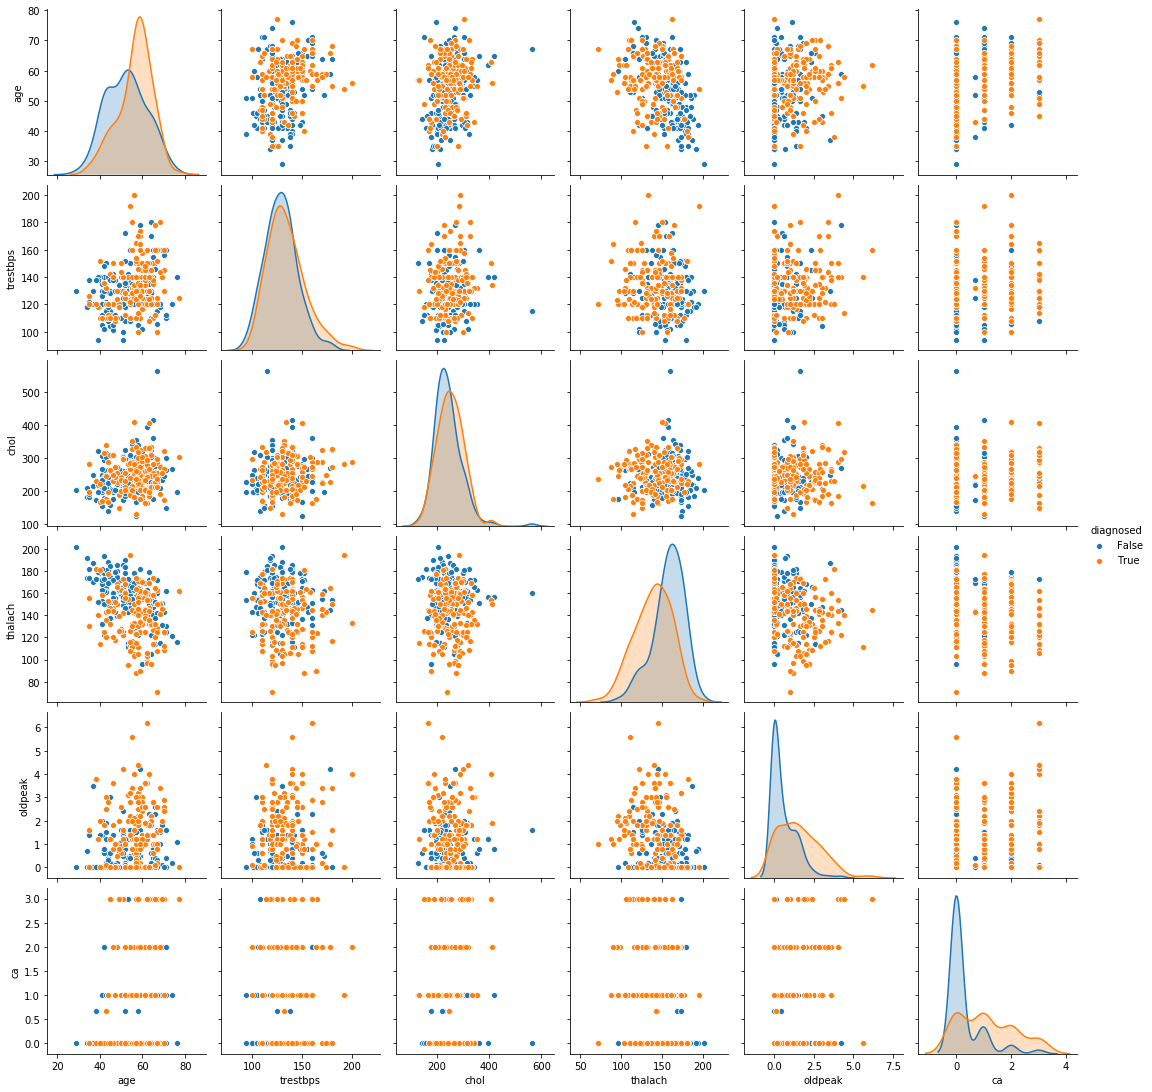

In [7]:
sns.pairplot(df, vars=cont_vars, hue='diagnosed')

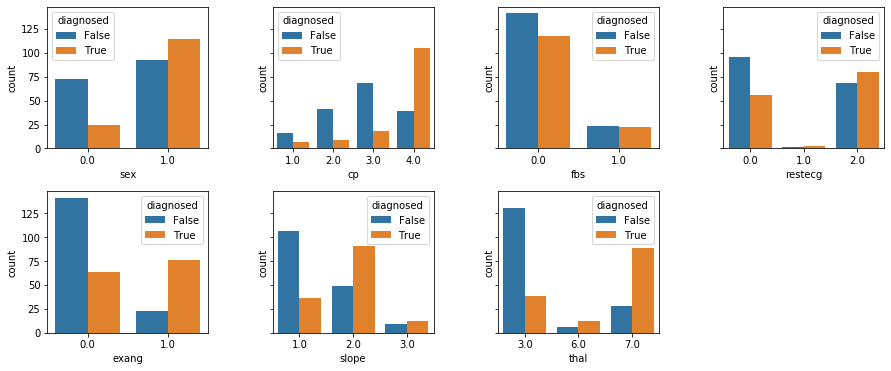

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(15,6), sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i == 7:
        plt.axis('off')
        break
    sns.countplot(x=cat_vars[i], data=df, hue='diagnosed', ax=ax)
    
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

OK, it looks like we can get some decent separation. Therse plots are too big for a report though... let's get some test statistics

In [9]:
f_score, p_val = f_classif(df[cont_vars], df.diagnosed)
dff = pd.DataFrame(np.asarray([f_score, p_val]).T, index=cont_vars, columns=['f_score', 'p_val'])

chisq, p_val2 = chi2(df[cat_vars], df.diagnosed)
dff2 = pd.DataFrame(np.asarray([chisq, p_val2]).T, index=cat_vars, columns=['chisq', 'p_val'])

dff = dff.append(dff2)
dff.sort_values('p_val')

,f_score,p_val,chisq
ca,79.721616,4.358947e-17,NaN
thal,NaN,5.863786e-16,65.482313
oldpeak,66.166707,1.097605e-14,NaN
thalach,63.419223,3.456965e-14,NaN
exang,NaN,6.886243e-10,38.052613
age,15.769637,8.955637e-05,NaN
cp,NaN,9.981719e-05,15.140160
restecg,NaN,3.279787e-03,8.644897
slope,NaN,4.088886e-03,8.243914
sex,NaN,6.404399e-03,7.432845


## Data preparation 

One-hot encoding for categorical features and standardisation

In [10]:
onehot_vars = ['cp', 'restecg', 'slope', 'thal']
enc = OneHotEncoder(sparse=False)
onehot_X = enc.fit_transform(df[onehot_vars])

In [11]:
X = np.hstack([df[[var for var in vars if var not in onehot_vars]], onehot_X])
y = df.diagnosed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=64)

scaler = StandardScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
print(X_train.shape)
print(X_test.shape)

(181, 22)
(122, 22)


## Logistic regression classifier

In [13]:
model = LogisticRegression(C=0.1, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

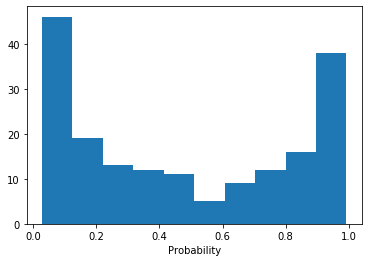

In [14]:
fig, ax = plt.subplots()
ax.hist(model.predict_proba(X_train)[:,1])
ax.set_xlabel("Probability")
plt.show()

In [15]:
model.score(X_train, y_train)

0.8674033149171271

In [16]:
model.score(X_test, y_test)

0.8524590163934426

In [17]:
coeffs = {}
names = iter([var for var in vars if var not in onehot_vars] + onehot_vars)
cat_sums = list(map(len, enc.categories_))

i = 0
while i < X_train.shape[1]:
    var = next(names)
    if var in onehot_vars:
        j = cat_sums[onehot_vars.index(var)]
        c_ = model.coef_[0, i:i+j]
        coeffs[var] = np.mean(np.abs(c_))
        i += j
        
    else:
        coeffs[var] = model.coef_[0, i]
        i += 1

In [18]:
dff['coef'] = pd.Series(coeffs)
dff.coef = abs(dff.coef)
dff.sort_values('coef', ascending=False)

,f_score,p_val,chisq,coef
ca,79.721616,4.358947e-17,NaN,0.663491
sex,NaN,6.404399e-03,7.432845,0.389213
oldpeak,66.166707,1.097605e-14,NaN,0.354986
exang,NaN,6.886243e-10,38.052613,0.335062
trestbps,7.006632,8.548269e-03,NaN,0.319189
thal,NaN,5.863786e-16,65.482313,0.219258
thalach,63.419223,3.456965e-14,NaN,0.208419
cp,NaN,9.981719e-05,15.140160,0.199283
slope,NaN,4.088886e-03,8.243914,0.196573
age,15.769637,8.955637e-05,NaN,0.125483


0.9447303921568628
0.9079520697167757


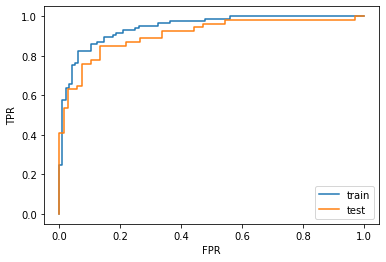

In [20]:
y_score_train = model.decision_function(X_train)
fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
plt.plot(fpr_train, tpr_train, label='train')
print(roc_auc_score(y_train, y_score_train))

y_score_test = model.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
plt.plot(fpr_test, tpr_test, label='test')
print(roc_auc_score(y_test, y_score_test))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()